In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle: ###particleweight
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): 
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)
        
    def observation_update(self, observation): 
        print(observation)

In [3]:
class Mcl: ###mclweight
    def __init__(self, init_pose, num, motion_noise_stds): 
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)] #引数を追加

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time):
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
            
    def observation_update(self, observation):   #メソッド追加
        for p in self.particles: p.observation_update(observation)
        
    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles]
        vys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class MclAgent(Agent): 
    def __init__(self, time_interval, nu, omega, particle_pose, particle_num=100,\
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}): 
        super().__init__(nu, omega)
        self.mcl = Mcl(particle_pose, particle_num, motion_noise_stds)
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None): 
        self.mcl.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.mcl.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.mcl.draw(ax, elems)

<IPython.core.display.Javascript object>


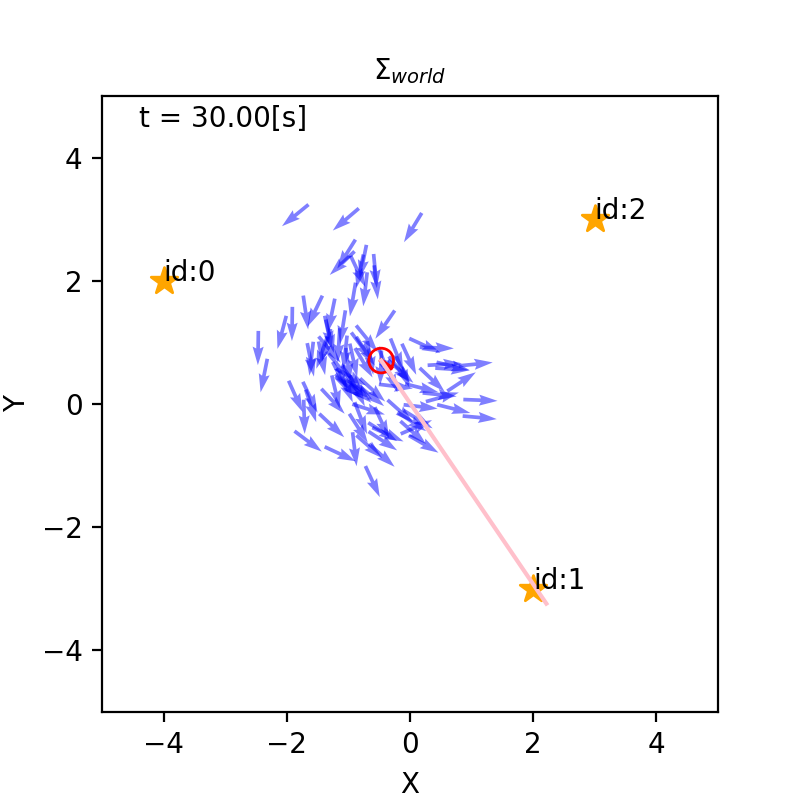

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1 #追加してWorld, MclAgentで利用
    world = World(30, time_interval) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T) #MclAgentに
    r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=circling, color="red")   #初期位置を原点に
    world.append(r)

    world.draw()                       # アニメーションさせるとき
    #r.one_step(time_interval)  # アニメーションなしでデバッグするとき